In [4]:
# manipulating and plotting arrays
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# file handling and units
import tarfile
from tqdm import tqdm
import astropy
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.utils.data import download_file
from lightkurve.search import search_lightcurve

# machine learning and data packages

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn import metrics
import scipy



#setting random seeds
seed = 42
np.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

# read from cloud datasets as opposed to downloading from on-premise servers
from astroquery.mast import Observations
Observations.enable_cloud_dataset()


%matplotlib inline

ModuleNotFoundError: No module named 'keras'

In [2]:
conda run pip install git+https://github.com/afeinstein20/stella

  Cloning https://github.com/afeinstein20/stella to /tmp/pip-req-build-wygryxnj
  Resolved https://github.com/afeinstein20/stella to commit f9ffd78d1c7279012e870f3657812595f18eee74
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

  Running command git clone --filter=blob:none --quiet https://github.com/afeinstein20/stella /tmp/pip-req-build-wygryxnj


Note: you may need to restart the kernel to use updated packages.


In [3]:
import stella

# Exercise 1

First, we download the relevant data and confirm that we've plotted the correct lightcurve.

In [ ]:
# ticids = ['278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']
ticids = ['234295610']


# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
lc.plot()

Now, we'd like to inspect the quality flags for those high-flux time stamps. First, we select those regions. Note that we slice the lightcurve using `flux.values`, because otherwise we wouldn't be able to compare the flux array to the unitless `1900` value.

Because there's a large time separation between these values (that would be joined by a straight line), let's scatter plot the points.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

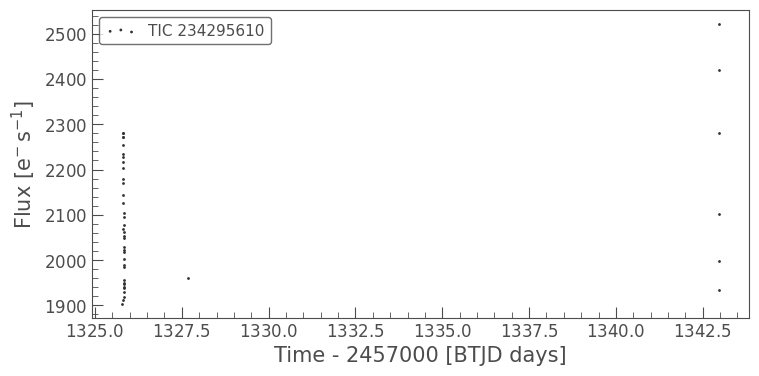

In [13]:
lc_check = lc[lc.flux.value>1900]
lc_check.scatter()

We'll use a code chunk from the [Quality Flags](../../02-quality-flags) notebook below.

In [27]:
quality = lc_check['quality']

bad_bits = np.array([1,2,3,4,5,6,8,10,12,13,15])
value = 0
for v in bad_bits:
    value = value + 2**(v-1)
    
bad_data = np.bitwise_and(quality, value) >= 1 

np.any(bad_data)

False

It seems that none of these high-flux timestamps were flagged by the TESS team as being bad-quality. This lends more credence to the idea that there is a real astrophysical source of the high flux — perhaps flares.

# Exercise 2

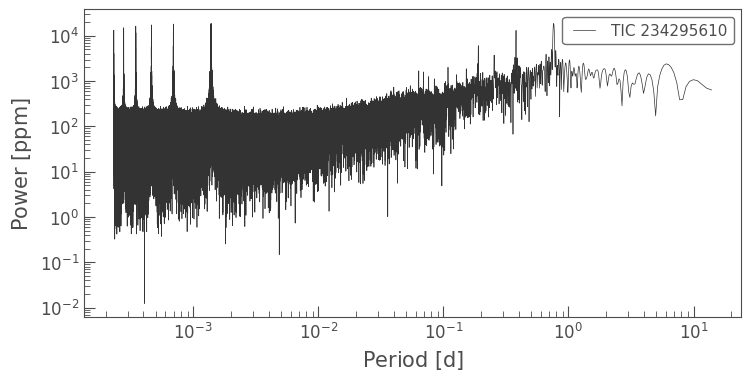

In [30]:
lc_interval = (lc.time.max() - lc.time.min()).value

max_period = lc_interval/2

min_period = 1 / 24 / 60 / 60 * 20

pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)

pg.plot(scale='log');

We'd like to investigate whether those peaks are harmonics

In [31]:
from scipy.signal import find_peaks

In [66]:
# peaks = find_peaks(pg.power, distance=2000)[0]
peaks = find_peaks(pg.power, height=12500, distance=800)[0]

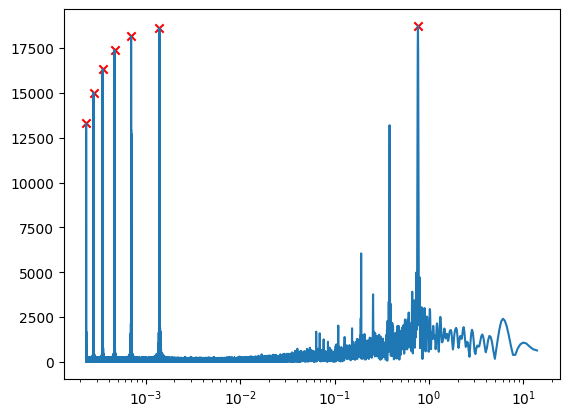

In [67]:
plt.plot(pg.period, pg.power)

plt.scatter(pg.period[peaks], pg.power[peaks], color='red', marker='x')
plt.xscale('log')

In [68]:
pg.period[peaks]

<Quantity [7.61765205e-01, 1.38636373e-03, 6.93813215e-04, 4.62682613e-04,
           3.47064660e-04, 2.77677030e-04, 2.31552268e-04] d>

In [70]:
first_harmonic = pg.period[peaks][1]

In [76]:
per_ratios = []
for per in pg.period[peaks][2:]:
    per_ratios += [first_harmonic/per]

per_ratios = np.array(per_ratios)
        

In [77]:
per_ratios

array([1.99818006, 2.99636013, 3.99454019, 4.99272026, 5.98726045])

Text(0.5, 0, 'Period ratio')

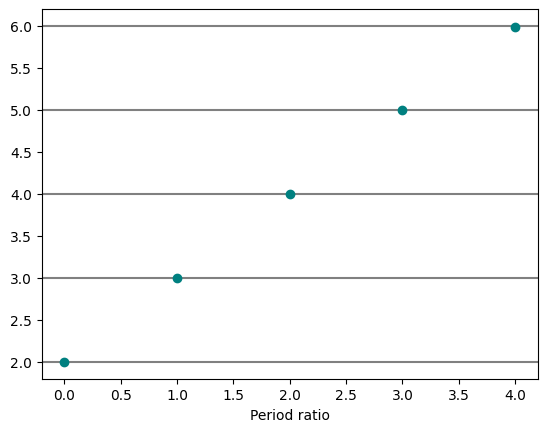

In [91]:
plt.axhline(2, color='gray')
plt.axhline(3, color='gray')
plt.axhline(4, color='gray')
plt.axhline(5, color='gray')
plt.axhline(6, color='gray')
plt.scatter(np.arange(len(per_ratios)), per_ratios, zorder=100, color='teal')

plt.xlabel('Peak number')
plt.xlabel('Period ratio')


The period ratios are close to integer values. Looks like harmonics here!

# Exercise 3

If we change this to just the 1-sigma outliers, the periodicity we're looking for is removed entirely. This is, in short, not good. The implication is that when cleaning our datasets, we should take care to not clean them so much that the signal of interest is removed.

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{ppm}$]'>

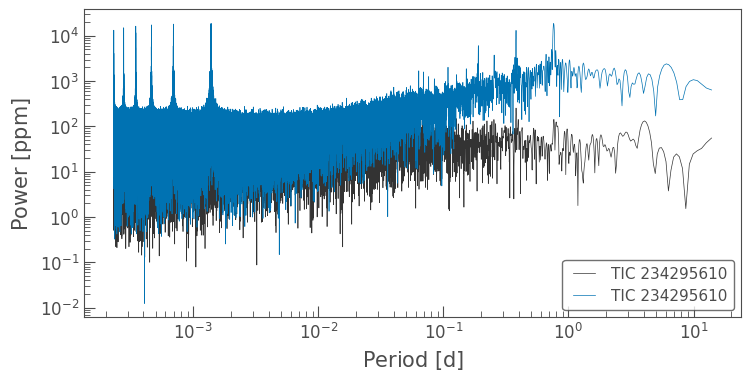

In [93]:
lc_clipped = lc.remove_outliers(sigma=1)

pg_clipped = lc_clipped.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)
ax = pg_clipped.plot(scale='log', zorder=1);

pg.plot(ax=ax, scale='log')

This makes sense when we take a look at the lightcurve that's been clipped. We've removed way too much of the lightcurve!

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

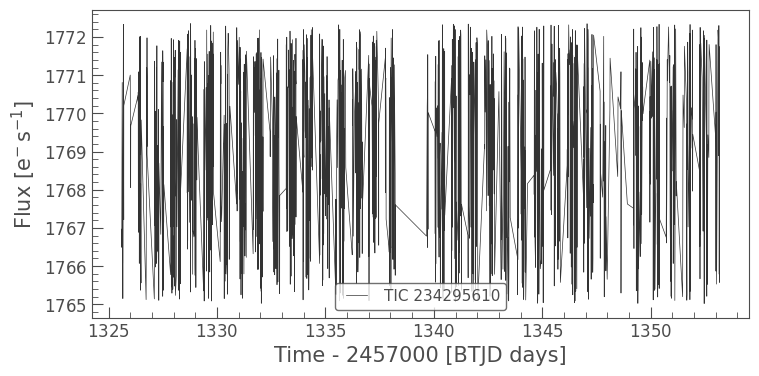

In [94]:
lc_clipped.plot()

# Exercise 4

In [96]:
data_dir = './hellouniverse_stella_500/'
filename = 'Guenther_2020_flare_catalog.txt'
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+filename) # using the same catalog as above

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 275.60it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



In [97]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]


In [98]:
# first, we load the mode.
cnn_file = 'initial_flare_model_small_dataset.h5' #AS: ask about where the files are from previous notebooks!
model = keras.models.load_model(cnn_file)

In [99]:
# set up the ConvNN object.
cnn_stella = stella.ConvNN(output_dir=data_dir, ds=ds)

In [100]:
cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


100%|██████████| 1/1 [00:05<00:00,  5.02s/it]


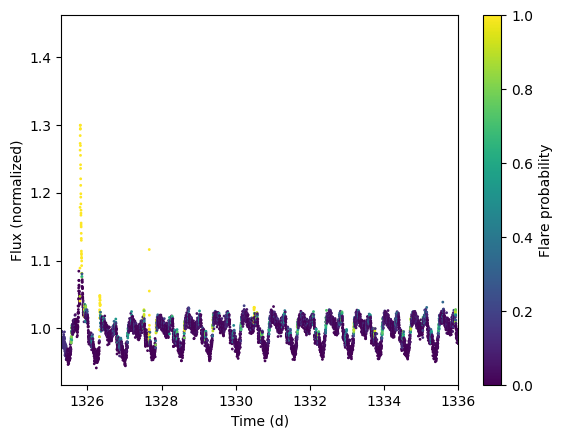

In [102]:
# cnn_stella.predict_flux[0]
fig, ax= plt.subplots()
im  = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
plt.xlabel('Time (d)')
plt.ylabel('Flux (normalized)')
plt.colorbar(im, label='Flare probability')
plt.xlim(lc.time.min().value, 1336)
plt.show()


Now, we'd like to count the number of distinct flares. Let's count a transition into and out of hgih flare probability (greater than a rating of 0.5 by the classifier) as a flare.

In [107]:
ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])

In [108]:
ff

In [110]:
ff.identify_flare_peaks(threshold=0.5)
ff.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
234295610.0,1336.5337294934927,1.0164458841762698,15.733979526711776,0.0001,0.01,0.7433666586875916
234295610.0,1336.6670634792652,1.030084465920081,77.18607677976796,0.01,0.01,0.503517746925354
234295610.0,1340.3767937687605,1.0188266236793928,19.615063032310957,0.0001,0.01,0.846248209476471
234295610.0,1341.9031816217816,1.0166045607867409,17.27435594647144,0.0001,0.01,0.5975300669670105
234295610.0,1344.9628970090544,1.0205275288684985,22.32319766900919,0.0001,0.01,0.715408205986023


These tell us a little more here! right now we're just going to count the flare rate in number of flares per day.

In [111]:
def calc_flare_rate(name):
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])
    
    ff.identify_flare_peaks(threshold=0.5)
    flare_rate = len(ff.flare_table) / (lc.time.value.max() - lc.time.value.min())    
    return flare_rate

Let's recalculate those rotation and flare rates.

In [130]:

G = const.G
M = 1 * u.M_sun
R = 1 * u.R_sun
vc = (G * M / R)**.5

P = 2 * np.pi * R  / vc

min_period = P.to(u.day).value/100

In [131]:
def calc_rotation_rate(name):
    """
    Calculates the roation period of a star, assuming that rotation is the primary driver of the star's periodicity. 
    
    Inputs
    ------
        :name: name of star (str)
        
    Outputs
    -------
        :period_at_max_power: the dominant period in the light curve. [float]
    """
    
    
    # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)
    
    return pg.period_at_max_power


filename = 'Guenther_2020_flare_catalog.txt'

catalog = astropy.io.ascii.read(data_dir + filename)  
stars = catalog['TIC'].data




rot_rates = []

# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    
    rot_rate = calc_rotation_rate(star_name)
    
    # store result of rotation rate calculation
    rot_rates += [rot_rate]

  0%|          | 0/44 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  2%|▏         | 1/44 [00:00<00:16,  2.54it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  7%|▋         | 3/44 [00:01<00:20,  2.03it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  9%|▉         | 4/44 [00:02<00:22,  1.81it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 11%|█▏        |

In [119]:
flare_rates = []
for star in stars[::200]:
    flare_rate = calc_flare_rate(str(star))
    
    flare_rates += [flare_rate]

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

569/569 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

537/537 [==============================] - 2s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 5ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 7ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

568/568 [==============================] - 4s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 7ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 3s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

541/541 [==============================] - 2s 4ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 7ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 7ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 7ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 7ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 3s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 7ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 7ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 4s 6ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 7ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 4s 6ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

554/554 [==============================] - 4s 7ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


In [132]:
rot_rates = [rot_rate.value for rot_rate in rot_rates]

/tmp/ipykernel_191/212443149.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal')


Text(0, 0.5, 'Period at max power (d)')

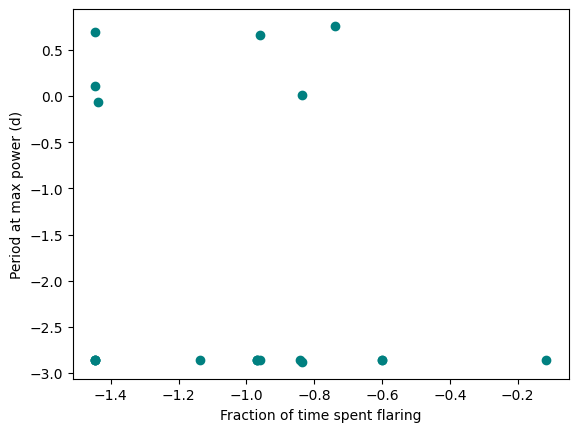

In [133]:
plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')

In [134]:
rot_rates, flare_rates = np.array(rot_rates), np.array(flare_rates)

In [135]:
rot_rates_cleaned = rot_rates[flare_rates>0.0]
flare_rates_cleaned = flare_rates[flare_rates>0.0]

In [136]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned))

In [137]:
x = np.linspace(np.min(np.log10(flare_rates_cleaned)), np.max(np.log10(flare_rates_cleaned)), 100)
y = slope * x + intercept

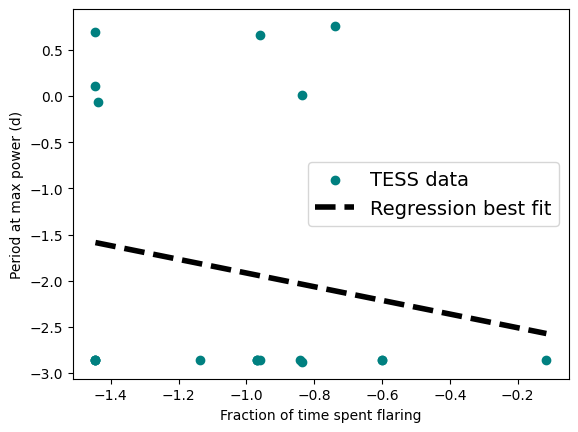

In [144]:
plt.scatter(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned), color='teal', label='TESS data')
plt.plot(x,y, color='black', linestyle='--', lw=4, label='Regression best fit')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')
plt.legend(fontsize=14);

In [139]:
slope, intercept

(-0.7410409138692633, -2.6577998704293533)

In [140]:
r_value**2

0.032676708574602586

In [151]:
r_value**2

0.032676708574602586

In [157]:
lc = lc.normalize()
lc = lc.remove_nans()


In [158]:
mProt = stella.MeasureProt([lc.targetid], [lc.time.value], [lc.flux.value], [lc.flux_err.value])


In [159]:
mProt.run_LS()


Finding most likely periods: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


In [164]:
mProt.LS_results['period_days'].value[0]


0.7617276563470238

In [169]:
def calc_rotation_rate_stella(name):
     # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    lc = lc.normalize()
    lc = lc.remove_nans()
    mProt = stella.MeasureProt([lc.targetid], [lc.time.value], [lc.flux.value], [lc.flux_err.value])
    mProt.run_LS()

    
    return mProt.LS_results['period_days'].value[0]
    

In [170]:

rot_rates = []

# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    
    rot_rate = calc_rotation_rate_stella(star_name)
    
    # store result of rotation rate calculation
    rot_rates += [rot_rate]

100%|██████████| 44/44 [00:17<00:00,  2.57it/s]


/tmp/ipykernel_191/212443149.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal')


Text(0, 0.5, 'Period at max power (d)')

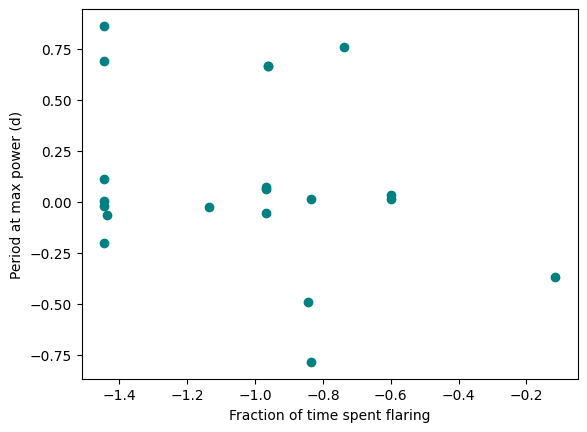

In [171]:
plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')

This is not nearly as tight a relationship. The number of flares must be measuring a fundamentally different quantity than the fraction of time spent flaring. Or, if the two metrics do measure the same quantity, this most recent approach must do so in a much more messy way. TODO: see whether the flare doesn't catch the things that drive the other trend! Maybe they get filtered out because they're not real flares. maybe they're oscillations. 

# Exercise 5

We can most easily solve this by writing a new function to find rotation periods.

In [172]:
mProt.LS_results

Target_ID,period_days,secondary_period_days,gauss_width,max_power,secondary_max_power,orbit_flag,oflag1,oflag2,Flags,avg_period_days
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
234295610,0.7617276563470238,0.761719892368407,0.014571099366043627,0.3948251840039057,0.04771755180136625,0.0,0.0,0.0,0,0.7617276563470238


In [174]:
def calc_rotation_rate_stella_constrained(name):
     # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    lc = lc.normalize()
    lc = lc.remove_nans()
    mProt = stella.MeasureProt([lc.targetid], [lc.time.value], [lc.flux.value], [lc.flux_err.value])
    mProt.run_LS()
    
    period_val = mProt.LS_results['period_days'].value[0]
    primary_power = mProt.LS_results['max_power'].value[0]
    secondary_power = mProt.LS_results['secondary_max_power'].value[0]
    width_val = mProt.LS_results['gauss_width'].value[0]
    
    # the checks on the rotation period defined in Feinstein+20
    period_constraint = period_val > 12
    width_constraint = width_val > 0.4 * period_val 
    secondary_constraint = (primary_power - secondary_power)/primary_power > 0.96
    
    if period_constraint or width_constraint or secondary_constraint:
        return np.nan

    return mProt.LS_results['period_days'].value[0]

In [175]:
rot_rates_constrained = []

# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    
    rot_rate = calc_rotation_rate_stella(star_name)
    
    # store result of rotation rate calculation
    rot_rates_constrained += [rot_rate]

100%|██████████| 44/44 [00:14<00:00,  2.97it/s]


In [179]:
len(rot_rates_constrained) == len(rot_rates)

True

Looks like we didn't lose any rotation rates by being more precise.

# Exercise 6

Now, let's be more stringent with our flares.

In [180]:
def calc_flare_rate(name):
    """
    todo: add docstring.
    """
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])
    
    ff.identify_flare_peaks(threshold=0.5)
    
    ff.flare_table
    flare_rate = len(ff.flare_table) / (lc.time.value.max() - lc.time.value.min())    
    return flare_rate

In [181]:
ff.flare_table

Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
234295610.0,1336.5337294934927,1.0164458841762698,15.733979526711776,0.0001,0.01,0.7433666586875916
234295610.0,1336.6670634792652,1.030084465920081,77.18607677976796,0.01,0.01,0.503517746925354
234295610.0,1340.3767937687605,1.0188266236793928,19.615063032310957,0.0001,0.01,0.846248209476471
234295610.0,1341.9031816217816,1.0166045607867409,17.27435594647144,0.0001,0.01,0.5975300669670105
234295610.0,1344.9628970090544,1.0205275288684985,22.32319766900919,0.0001,0.01,0.715408205986023


In [182]:
# ok, I think that the flare-finding thing already does this.
                              

# Exercise 7

Now, let's assess the statistical signficance of our fit. There are a number of ways to do this, but one of the more rigorous is Bayesian model selection. Basically, we'll fit a linear model to our data and see if it is preferred over a flat line (with no relationship between our quantities).

The below will borrow heavily from the emcee documentation. (todo: link)

NOTE: IS THIS STILL FEASIBLE?

In [1]:
import emcee

In [ ]:
def model(x,  period, phase, amplitude, offset):
    """
    returns a sine wave 
    """
    freq = 2 * np.pi / period
    return amplitude * np.sin(freq * x + phase) + offset

We can set uniform priors on the period within 50% on each side, to be generous.

Note: is this problematic because it's not in linear space?

In [ ]:
period_fit = 10

In [ ]:
def log_prior(theta):
    """
    some docstring here describing this as a top-hat prior.
    """
    period, phase, amplitude, offset, log_f = theta
    
    
    period_width = 0.5 * period_fit
    period_max = period_fit + period_width
    period_min = period_fit - period_width
    
    phase_min = 0
    phase_max = 2 * np.pi # a full phase is 2pi
    
    amplitude_min = 0
    amplitude_max = 10 # generous amplitude given the detrending
    
    offset_min = 0
    offset_max = 2 # the phase curves should generally be normalized at 1.
    
    # these estimates come from the emcee line-fitting tutorial.
    log_f_min = -10
    log_f_max = 1
    
    
    if period_min < period < period_max \
            and phase_min < phase < phase_max \
            and amplitude_min < amplitude < amplitude_max \
            and offset_min < offset < offset_max \
            and log_f_min < log_f < log_f_max:
        
        return 0.0
    
    # want to strongly penalize any walker that steps outside the prior.
    return -np.inf

In [ ]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
def log_likelihood(theta, x, y, yerr):
    period, phase, amplitude, offset, log_f = theta
    model = calc_model(x,  period, phase, amplitude, offset)
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [ ]:
# todo: reset x and y and yerr

n_dim = 5
n_walkers = 32 # seems fine. justify?
n_steps = 5000 # seems fine. justify?

initial_point = np.array([]) # incorporate as an array and not a list so that we can add to it, etc.
gaussian_scatter_level = 1e-4 # seems fine. justify?

# add some scatter to the walkers around the initial position.
pos = initial_point + gaussian_scatter_level * np.random.randn(n_walkers, ndim)

sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, n_steps, progress=True);

In [ ]:
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['period', 'phase', 'amplitude', 'offset', 'log_f']

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
# well, what's the error on it? let's say it's the width.

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=labels
);

Now that we've fit the primary periods, let's fit the underlying trend with a line!

or maybe i should gaussian process the whole thing. I feel like that adds too much mathematical complexity, though!

In [ ]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [ ]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [ ]:

# todo: reset x and y and yerr
n_dim = 3
n_walkers = 32 # seems fine. justify?
n_steps = 5000 # seems fine. justify?

initial_point = np.array([]) # incorporate as an array and not a list so that we can add to it, etc.
gaussian_scatter_level = 1e-4 # seems fine. justify?

# add some scatter to the walkers around the initial position.
pos = initial_point + gaussian_scatter_level * np.random.randn(n_walkers, ndim)

sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, n_steps, progress=True);

fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'b', 'log_f']

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels
);

In [ ]:
# now let's fit a flat line to the data.

def log_prior(theta):
    b, log_f = theta
     0.0 < b < 2 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    b, log_f = theta
    model =  b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


# todo: reset x and y and yerr
n_dim = 2
n_walkers = 32 # seems fine. justify?
n_steps = 5000 # seems fine. justify?

initial_point = np.array([]) # incorporate as an array and not a list so that we can add to it, etc.
gaussian_scatter_level = 1e-4 # seems fine. justify?

# add some scatter to the walkers around the initial position.
pos = initial_point + gaussian_scatter_level * np.random.randn(n_walkers, ndim)

sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, n_steps, progress=True);

fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'b', 'log_f']

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels
);

In [ ]:
def calc_bic(log_likelihood, n_points, n_params):
    """
    calculates the Bayesian Information Criterion.
    """
    bic = -2 * log_likelihood + log(n_points) * n_params
    return bic

In [ ]:
# do BIC.
log_likelihood_trend = ...(theta, x, y, yerr) # slice through the middle!
log_likelihood_flat = ...(theta, x, y, yerr) # slice through the middle!

bic_trend = calc_bic(log_likelihood_trend, n_points, n_params)
bic_flat = calc_bic(log_likelihood_flat, n_points, n_params)

delta_bic = bic_trend - bic_flat



We've calcualted a $\Delta$BIC of __. In general, we look for a $\Delta$BIC greater than 2 before we consider the data to prefer one model over the other (cite?).

That's a long way of saying that the trend we found was not statistically significant — even though it aligned with our predictions!

That's not to say that our approach is flawed. It may be that further observations could help us differentiate between a trend and a flat line.

In [ ]:
def BI